In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, poisson
import matplotlib.pyplot as plt
from py_scripts.common import QuantitiesOfInterest
from scipy.stats import gaussian_kde



# World Cup Problem via Grid Approximation and pymc3

++++++++++++++++++++++++++++++ 
Posterior Values of lambda:
The expected value is: 2.699772393342307
The MAP is: 2.2
The CI is: [1.1, 4.800000000000001]
++++++++++++++++++++++++++++++ 
Posterior Predictive:
The expected value is: 2.694
The MAP is: 3
The CI is: [0, 7]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lbd]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2 seconds.


++++++++++++++++++++++++++++++ 
Posterior Values of lambda (pymc3):
The expected value is: 2.7158443549883136
The MAP is: 2.1
The CI is: [1.0, 5.0]
++++++++++++++++++++++++++++++ 
Posterior Predictive (pymc3):
The expected value is: 2.73
The MAP is: 1
The CI is: [0, 7]


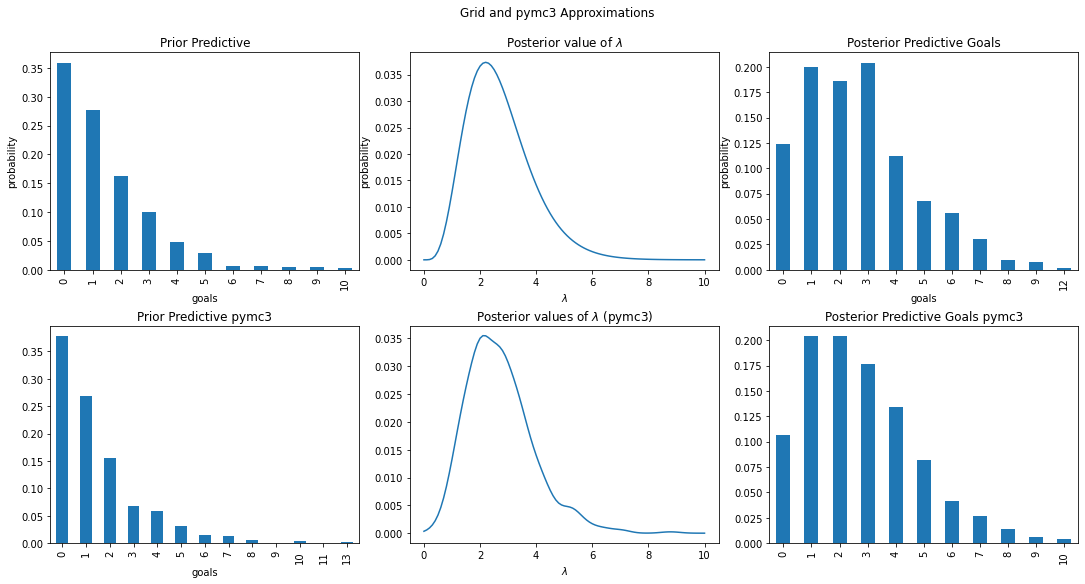

In [2]:
# configure the plots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.tight_layout(h_pad=4, w_pad=2)
fig.suptitle('Grid and pymc3 Approximations')
plt.subplots_adjust(top=0.9)

# Create a grid approximation of the world cup problem
alpha = 1.4
data = 4
lbds = np.linspace(0, 10, 101)
prior_dist = gamma(alpha)

# Extract the prior predictive dist as we did in previous chapters: by sampling
sample_prior = prior_dist.rvs(1000)
sample_prior_pred = pd.Series(poisson.rvs(sample_prior), name="samples")
pmf = sample_prior_pred.groupby(sample_prior_pred).count()
pmf /= pmf.sum()
_ = pmf.plot(
    kind="bar", title="Prior Predictive", xlabel="goals", ylabel="probability",
    ax=ax[0][0]
)

# Compute the likelihood
prior = prior_dist.pdf(lbds)
likes = poisson(lbds).pmf(data)  # 4 goals under each lambda hypothesis
posterior = prior * likes
posterior /= posterior.sum()
posterior = pd.Series(posterior, index=lbds)
posterior.index.name = "lambda"
print(30 * "+", "\nPosterior Values of lambda:")
QuantitiesOfInterest(posterior).run()
_ = posterior.plot(
    title="Posterior value of $\lambda$", xlabel="$\lambda$", ylabel="probability",
    ax=ax[0][1]
)

# Sample posterior predictive
lbds_series = pd.Series(lbds)
lbds_samples = lbds_series.sample(500, replace=True, weights=posterior.values)
posterior_pred = pd.Series(poisson.rvs(lbds_samples))
posterior_pred = posterior_pred.groupby(posterior_pred).count()
posterior_pred /= posterior_pred.sum()
print(30 * "+", "\nPosterior Predictive:")
QuantitiesOfInterest(posterior_pred).run()
_ = posterior_pred.plot(
    kind="bar", title="Posterior Predictive Goals", ax=ax[0][2],
    xlabel="goals", ylabel="probability",
)

import pymc3 as pm

# Create the model in pymc3
with pm.Model() as world_cup_model:
    lbd = pm.Gamma("lbd", alpha=1.4, beta=1)
    goals = pm.Poisson("goals", lbd, observed=4)
    samples = pm.sample_prior_predictive(1000)

# Grab some samples from the prior predictive
counts = pd.DataFrame(samples).groupby("goals").lbd.count()
counts /= counts.sum()
counts.plot(kind="bar", title="Prior Predictive pymc3", xlabel="goals", ax=ax[1][0])

# Generate posteriors
with world_cup_model:
    posterior = pm.sample(500, return_inferencedata=False)
    post_pred_pymc3 = pm.sample_posterior_predictive(posterior)

posterior_pymc3 = gaussian_kde(posterior["lbd"]).pdf(lbds)
posterior_pymc3 /= posterior_pymc3.sum()
posterior_pymc3 = pd.Series(posterior_pymc3, index=lbds)
print(30 * "+", "\nPosterior Values of lambda (pymc3):")
QuantitiesOfInterest(posterior_pymc3).run()
posterior_pymc3.plot(
    title="Posterior values of $\lambda$ (pymc3)", xlabel="$\lambda$", ax=ax[1][1]
)

goals = post_pred_pymc3["goals"]
post_pred_pymc3 = pd.Series(goals).groupby(goals).count()
post_pred_pymc3 /= post_pred_pymc3.sum()
print(30 * "+", "\nPosterior Predictive (pymc3):")
QuantitiesOfInterest(post_pred_pymc3).run()
_ = post_pred_pymc3.plot(
    kind="bar", title="Posterior Predictive Goals pymc3", ax=ax[1][2]
)



# Happiness Problem

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, m, x0]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 4 seconds.


Text(0.5, 0, 'm Value')

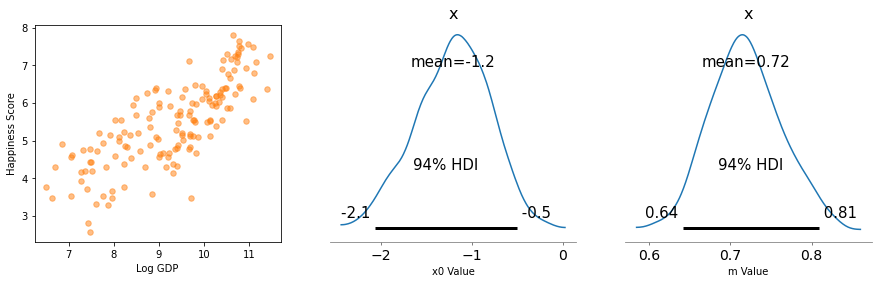

In [3]:
import arviz as az
import statsmodels.formula.api as smf
from scipy.stats import linregress
import matplotlib.pyplot as plt
# Get the data
filename = 'WHR20_DataForFigure2.1.xls'
df = pd.read_excel(filename)
mapping = {
    'Ladder score': "score",
    'Logged GDP per capita': "gdp",
    'Social support': "social",
    'Healthy life expectancy': "health",
    'Freedom to make life choices': "freedom",
    'Generosity': "generosity",
    'Perceptions of corruption': "corruption",
}
df = df.rename(columns=mapping)

_, ax = plt.subplots(ncols=3, figsize=(15, 4))


# plot score against gdp
_ = df.plot(
    kind="scatter", x="gdp", y="score", xlabel="Log GDP", ylabel="Happiness Score",
    s=30, alpha=.5, color="C1", ax=ax[0]
)

# get regressors using either scipy.stats.linregress or statsmodels
formula = 'score ~ gdp'
r1 = smf.ols(formula, data=df[["score", "gdp"]]).fit()
r2 = linregress(df.gdp, df.score)

# compute a pymc model with a normal distribution for the observations and uniform 
# distributions for a(0, 4), b(-4, 4) and sigma(0, 2).
try:
    traces
except NameError:
    with pm.Model() as glm:
        x0 = pm.Uniform("x0", -4, 4)
        m = pm.Uniform("m", 0, 4)
        sigma = pm.Uniform("sigma", 0, 2)

        y_hat = x0 + m * df.gdp
        y = pm.Normal("y_hat", mu=y_hat, sd=sigma, observed=df.score)
        traces = pm.sample(500, progressbar=False, return_inferencedata=False)

# plot the posteriors using az.plot_posterior
az.plot_posterior(traces["x0"], ax=ax[1])
az.plot_posterior(traces["m"], ax=ax[2])
ax[1].set_xlabel("x0 Value")
ax[2].set_xlabel("m Value")

In [4]:
# Multiple regression
# Standarize the distribution so they have mean 0 and 1 std
cols = [col for col in mapping.values()]

norm_df = df[cols].copy()
norm_df = (norm_df - norm_df.mean(axis=0)) / norm_df.std(axis=0)

# can linregress above be used with 7 parameters?
formula = 'score ~ gdp + social + health + freedom + generosity + corruption'
r1 = smf.ols(formula, data=norm_df).fit()

# Write the pymc model for all the 7 parameters
features = cols.copy()
features.pop(features.index("score"))
with pm.Model() as glm_7:
    x0 = pm.Uniform("x0", -4, 4)
    b0, b1, b2, b3, b4, b5 = [pm.Uniform(feat, -4, 4) for feat in features]
    sigma = pm.Uniform("sigma", 0, 2)
    y_hat = (
        x0 + b0 * norm_df[features[0]]
        + b1 * norm_df[features[1]]
        + b2 * norm_df[features[2]]
        + b3 * norm_df[features[3]]
        + b4 * norm_df[features[4]]
        + b5 * norm_df[features[5]]
    )
    y = pm.Normal("y", mu=y_hat, sd=sigma, observed=norm_df.score)
    trace = pm.sample(500, return_inferencedata=False, target_accept=.9)


# Createa table with the posterior means and the CIs

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, corruption, generosity, freedom, health, social, gdp, x0]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 4 seconds.


In [5]:
with glm_7:
    summary = az.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,-0.000,0.041,-0.079,0.076,0.001,0.001,1001.0,712.0,1.00
gdp,0.248,0.093,0.071,0.419,0.004,0.003,653.0,584.0,1.00
social,0.295,0.073,0.163,0.434,0.002,0.002,989.0,779.0,1.00
health,0.225,0.082,0.069,0.374,0.003,0.002,696.0,815.0,1.00
freedom,0.190,0.054,0.092,0.293,0.002,0.001,895.0,704.0,1.00
generosity,0.056,0.045,-0.036,0.132,0.001,0.001,1017.0,793.0,1.01
corruption,-0.098,0.049,-0.189,-0.009,0.002,0.001,937.0,789.0,1.00
sigma,0.515,0.031,0.454,0.570,0.001,0.001,1062.0,684.0,1.01


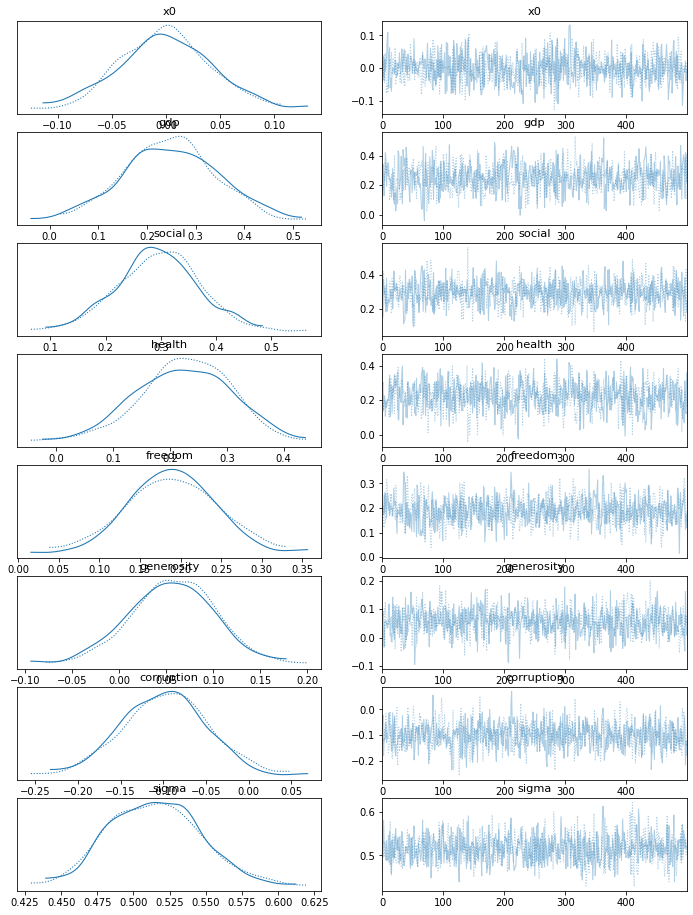

In [6]:
with glm_7:
    az.plot_trace(trace)

## Write a small markov chain

In [7]:
np.log(.100994)

-2.2926941698460745

In [8]:
import numpy as np
STATES = "A", "E"
np.random.seed(12345)
def jump(current_state):
    assert current_state in STATES
    p = np.random.uniform()

    # We are in A
    if current_state == STATES[0]:
        if p >= .4:  # Probability of remain in A: .6
            return STATES[0]
        return STATES[1]  # Probability to jump to E: .4

    # We are in E
    if p >= .7:  # probability of remain in E: .3
        return STATES[1]
    return STATES[0]  # probability to jump to A: .7

states_tape = [STATES[0], ]
for _ in range(15):
    current_state = states_tape[-1]
    new_state = jump(current_state)
    states_tape.append(new_state)

print(" -> ".join(states_tape))

A -> A -> E -> A -> E -> A -> A -> A -> A -> A -> A -> A -> A -> E -> A -> E


## The Metropolis-hastings algorithm

In [9]:
from scipy.stats import poisson, norm
np.random.seed(12345)
y = poisson(2).rvs(20).sum()  # some int like 52
p = np.ones(1000)
for i in range(1, p.size):
    r = p[i - 1]  # pick last state
    q = np.exp(np.log(r) + norm().rvs(1) / 9)[0] # Get a candidate
    candidate_probability = (q**y) * (r**(-y)) * np.exp(-20*(q-r))

    # determine next step
    if candidate_probability > np.random.uniform():
        p[i] = q
    else:
        p[i] = r